In [28]:
# import tensorflow as tf
# import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model

# from tensorflow.keras.layers import (
#     Input,
#     Dense,
#     Reshape,
#     Flatten,
#     Dropout,
#     BatchNormalization,
#     Activation,
#     ZeroPadding2D,
#     LeakyReLU,
#     UpSampling2D,
#     Conv2D,
#     Convolution2D,
#     MaxPooling2D,
#     Concatenate,
#     GaussianNoise,
#     GaussianDropout,
#     Lambda,
#     GlobalAveragePooling2D,
# )

# from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.utils import to_categorical

# import h5py
# import pickle
# import csv

import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

# import os
# import pathlib
# from pathlib import Path

# import time

# import math

In [2]:
path_all_tfrecord = "fp56.tfrecord"

# path_train_tfrecord = "fp56_train.tfrecord"
# path_test_tfrecord = "fp56_test.tfrecord"

In [3]:
dir_model = "vgg_cam/"
path_best = dir_model + "model-17-1.17-53.3%.hdf5"
path_best

'vgg_cam/model-17-1.17-53.3%.hdf5'

# load

In [4]:
df = pd.read_csv("vgg_5y_prediction.csv", index_col=0)
df

,ID,true,prediction
0,8928_160,6,6
1,8928_183,6,6
2,8928_201A,6,7
3,8928_204B,6,6
4,960_35,2,4
...,...,...,...
50247,115454_21D,9,9
50248,115454_34E,9,9
50249,115454_36B,9,9
50250,115454_37A,9,9


In [5]:
predictions = df.prediction.to_numpy()
predictions

array([6, 6, 7, ..., 9, 9, 9])

In [6]:
year_true = df.true.to_numpy()
year_true

array([6, 6, 6, ..., 9, 9, 9])

In [7]:
ids = df.ID.tolist()
ids[60:70]

['1321_195',
 '1327_105',
 '1327_158',
 '1327_193',
 '17533_140A',
 '17533_143B',
 '17533_179',
 '17533_203',
 '8431_54',
 '26196_163']

# run

In [9]:
from fp_tensorflow import _parse_pair_56, _parse_single_56
from fp_tensorflow import create_pair_56_dataset, create_single_dataset
from fp_tensorflow import VGG16_convolutions
from fp_tensorflow import create_vgg_5y_model

all_dataset = create_pair_56_dataset(path_all_tfrecord, "floorplan", "year").batch(64)

model = create_vgg_5y_model()
model.load_weights(path_best)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 56, 56, 6)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 56, 56, 64)        3520      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

In [11]:
# Get the 512 input weights to the softmax.
class_weights = model.layers[-1].get_weights()[0]

In [12]:
class_weights.shape

(512, 10)

In [13]:
class_weights.mean(), class_weights.std()

(0.00048049624, 0.10877906)

<AxesSubplot:ylabel='Density'>

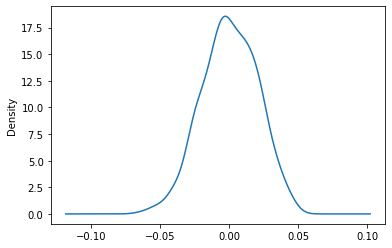

In [26]:
pd.Series(class_weights.mean(axis=1)).plot.kde()

In [23]:
# bias for 10 of 5-year classes
# model.layers[-1].get_weights()[1]

# global average pool output

In [29]:
gap_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [30]:
gap_outputs = gap_model.predict(all_dataset, verbose=1)

    786/Unknown - 283s 359ms/step

In [32]:
gap_outputs.shape, gap_outputs.mean(), gap_outputs.std()

((50252, 512), 0.18569908, 0.20326832)

<AxesSubplot:ylabel='Density'>

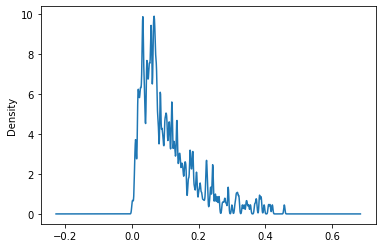

In [41]:
pd.Series(gap_outputs[116]).plot.kde(bw_method=0.02)

In [42]:
df_gap = pd.DataFrame(gap_outputs)
df_gap

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.142803,0.400475,0.134664,0.075232,0.161829,0.335772,0.034391,0.178221,0.228338,0.079080,...,0.218878,0.476947,0.042160,0.302460,0.281130,0.048943,0.092393,0.308245,0.176064,0.020658
1,0.153040,0.369468,0.343546,0.159964,0.177989,0.296884,0.026182,0.111398,0.232975,0.071310,...,0.136407,0.148069,0.051981,0.146548,0.241734,0.123167,0.069215,0.228878,0.172204,0.022260
2,0.105058,0.218708,0.427899,0.148000,0.038263,0.384796,0.042876,0.116903,0.126105,0.052608,...,0.233396,0.153381,0.012768,0.152117,0.134829,0.057846,0.071152,0.054373,0.067675,0.016740
3,0.126020,0.440626,0.223603,0.133866,0.113369,0.259057,0.200247,0.128830,0.304532,0.143829,...,0.191846,0.366552,0.021012,0.415277,0.288085,0.273792,0.198327,0.299434,0.222212,0.117026
4,0.158089,0.062936,0.228385,0.224262,0.195025,0.133689,0.054723,0.104017,0.008573,0.202741,...,0.084686,0.025523,0.125536,0.059776,0.009763,0.124605,0.063370,0.249394,0.058870,0.029997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50247,0.024017,0.529761,0.392485,0.132199,0.021490,0.708420,0.004376,0.071726,0.014480,0.544205,...,0.359036,0.178483,0.105762,0.381127,0.000000,0.587985,0.079742,0.005765,0.006367,0.017379
50248,0.093362,0.533998,0.405788,0.156721,0.002338,0.579458,0.044787,0.176960,0.009811,0.499926,...,0.436967,0.315911,0.208208,0.438174,0.037188,0.589422,0.043713,0.023868,0.026106,0.019453
50249,0.014703,0.549547,0.378694,0.142741,0.018892,0.649889,0.018734,0.098782,0.029179,0.936829,...,0.336168,0.285051,0.175838,0.394663,0.037916,0.547642,0.040543,0.025586,0.012245,0.010893
50250,0.130718,0.577925,0.353213,0.089060,0.038444,0.597074,0.022201,0.076431,0.010245,0.433426,...,0.380023,0.363627,0.118584,0.550807,0.023213,0.756092,0.035423,0.017822,0.040728,0.006346


In [43]:
df_gap.to_csv("vgg_5y_activation.csv.gz")